In [8]:
school_dic = {   
'ironhack' : 10828,
'app-academy' : 10525,
'springboard' : 11035,
'le-wagon' : 10868,
'general-assembly' : 10761,
'hackwagon-academy' : 10792,
'udacity' : 11118,
'thinkful' : 11098,
'nyc-data-science-academy' : 10925,    
}

import re
import pandas as pd
from pandas.io.json import json_normalize
import requests



def get_comments_school(school):
  TAG_RE = re.compile(r'<[^>]+>')
  # defines url to make api call to data -> dynamic with school if you want to scrape competition
  url = "https://www.switchup.org/chimera/v1/school-review-list?mainTemplate=school-review-list&path=%2Fbootcamps%2F" + school + "&isDataTarget=false&page=3&perPage=10000&simpleHtml=true&truncationLength=250"
  #makes get request and converts answer to json
  data = requests.get(url).json()
  #converts json to dataframe
  reviews =  pd.DataFrame(data['content']['reviews'])
  
  #aux function to apply regex and remove tags
  def remove_tags(x):
    return TAG_RE.sub('',x)
  reviews['review_body'] = reviews['body'].apply(remove_tags)
  reviews['school'] = school
  return reviews


# could you write this as a list comprehension? :)
comments = []

for school in school_dic.keys():
    print(school)
    comments.append(get_comments_school(school))

comments = pd.concat(comments)

from pandas.io.json import json_normalize

def get_school_info(school, school_id):
    url = 'https://www.switchup.org/chimera/v1/bootcamp-data?mainTemplate=bootcamp-data%2Fdescription&path=%2Fbootcamps%2F'+ str(school) + '&isDataTarget=false&bootcampId='+ str(school_id) + '&logoTag=logo&truncationLength=250&readMoreOmission=...&readMoreText=Read%20More&readLessText=Read%20Less'

    data = requests.get(url).json()

    data.keys()

    courses = data['content']['courses']
    courses_df = pd.DataFrame(courses, columns= ['courses'])

    locations = data['content']['locations']
    locations_df = json_normalize(locations)

    badges_df = pd.DataFrame(data['content']['meritBadges'])
    
    website = data['content']['webaddr']
    description = data['content']['description']
    logoUrl = data['content']['logoUrl']
    school_df = pd.DataFrame([website,description,logoUrl]).T
    school_df.columns =  ['website','description','LogoUrl']

    locations_df['school'] = school
    courses_df['school'] = school
    badges_df['school'] = school
    school_df['school'] = school
    
    # how could you write a similar block of code to the above in order to record the school ID?

    return locations_df, courses_df, badges_df, school_df

locations_list = []
courses_list = []
badges_list = []
schools_list = []

for school, id in school_dic.items():
    a,b,c,d = get_school_info(school,id)
    locations_list.append(a)
    courses_list.append(b)
    badges_list.append(c)
    schools_list.append(d)
    
locations = pd.concat(locations_list)
courses = pd.concat(courses_list)
badges = pd.concat(badges_list)
schools = pd.concat(schools_list)

#cleaning comments
def clean_comments(comments):
    #Changes in types
    comments['overallScore'] = comments['overallScore'].astype('float')
    comments['curriculum'] = comments['curriculum'].astype('float')
    comments['jobSupport'] = comments['jobSupport'].astype('float')
    comments['id'] = comments['id'].astype('object')
    comments['queryDate'] = pd.to_datetime(comments['queryDate'])
    #Change type and clean graduating years
    def correct_year(x):
        YEAR_RE = re.compile(r'\..')
        return YEAR_RE.sub('',x)
    import datetime
    comments["graduatingYear"] = comments["graduatingYear"].astype(str).apply(correct_year)
    #Dropping unecessary columns
    drop_cols = ["user", "body", "createdAt", "comments", "hostProgramName"]   
    comments = comments.drop(drop_cols, axis=1)
    #Renaming columns
    comments.rename(columns={'review_body': 'Review'}, inplace=True)
    #Substituting nulls
    comments = comments.fillna('not available')
    comments["jobTitle"]=comments["jobTitle"].where(comments["jobTitle"]!="" ,"not available")
    return comments

#cleaning locations
def clean_locations(locations):
    locations['id'] = locations['id'].astype('object')
    locations['city.id'] = locations['city.id'].astype('object')
    locations['country.id'] = locations['country.id'].astype('object')
    locations['state.id'] = locations['state.id'].astype('object')
    locations['city.id'] = locations['city.id'].astype('object')
    locations = locations.fillna('not available')
    return locations

#cleaning badges
def clean_badge_school(badges):
    TAG_RE = re.compile(r'<[^>]+>')
    def remove_tags(x):
        return TAG_RE.sub('',x)
    badges['description'] = badges['description'].apply(remove_tags)
    return badges

#Getting new versions goinggg
comments = clean_comments(comments) 
locations = clean_locations(locations)
badges = clean_badge_school(badges)
schools = clean_badge_school(schools)


#Cretion of table with relation between scholls and id
id_df=pd.DataFrame(school_dic.items(), columns=["school","school_id"])

#Adding the id of schools to evey column
locations = locations.merge( id_df, how="inner", left_on='school', right_on='school')
comments = comments.merge( id_df, how="inner", left_on='school', right_on='school')
badges = badges.merge( id_df, how="inner", left_on='school', right_on='school')
schools = schools.merge( id_df, how="inner", left_on='school', right_on='school')
courses = courses.merge( id_df, how="inner", left_on='school', right_on='school')



print(locations,comments,badges,schools,courses)

ironhack
app-academy
springboard
le-wagon
general-assembly
hackwagon-academy
udacity
thinkful
nyc-data-science-academy


<ipython-input-8-b4cd5b19a280>:59: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  locations_df = json_normalize(locations)


       id                       description     country.id   country.name  \
0   15901                   Berlin, Germany             57        Germany   
1   16022               Mexico City, Mexico             29         Mexico   
2   16086            Amsterdam, Netherlands             59    Netherlands   
3   16088                 Sao Paulo, Brazil             42         Brazil   
4   16109                     Paris, France             38         France   
..    ...                               ...            ...            ...   
90  16479              Singapore, Singapore             56      Singapore   
91  15807                            Online  not available  not available   
92  16383                            Online  not available  not available   
93  15946  New York City, NY, United States              1  United States   
94  16153                            Online  not available  not available   

   country.abbrev        city.id      city.name   city.keyword       state.

In [7]:
locations.head()

NameError: name 'locations' is not defined

In [3]:
comments.head()

,id,name,anonymous,graduatingYear,isAlumni,jobTitle,tagline,queryDate,program,overallScore,overall,curriculum,jobSupport,Review,school,school_id
0,270766,salim ameur,False,2020,False,frontend developer,"""An amazing experience !""",2020-11-23,Web Development Bootcamp,5,5.0,5,5,IRONHACK will be the best choice if you want t...,ironhack,10828
1,270471,michael moyers,False,2020,False,Product Designer,Exceeded my expectations and beyond!,2020-11-16,UX/UI Design Bootcamp,5,5.0,5,5,I could not be more impressed with my experien...,ironhack,10828
2,270296,Anonymous,True,2020,False,not available,Very intense and high reward bootcamp,2020-11-13,Web Development Bootcamp,4.7,5.0,4,5,Ironhack bootcamp is a unique experience where...,ironhack,10828
3,270295,VALENTINE CONQ,False,2020,False,Product Designer,"Great bootcamp, amazing humans.",2020-11-13,UX/UI Design Bootcamp,5,5.0,5,5,I attended the UX/UI bootcamp at Ironhack and ...,ironhack,10828
4,270282,Ailie McCorkindale,False,2020,False,not available,Highly Recommended Bootcamp!,2020-11-12,Web Development Bootcamp,5,5.0,5,5,I'm really happy I made the decision to join I...,ironhack,10828


In [5]:
badges.head()

,name,keyword,description,school,school_id
0,Available Online,available_online,School offers fully online courses,ironhack,10828
1,Verified Outcomes,verified_outcomes,School publishes a third-party verified outcom...,ironhack,10828
2,Flexible Classes,flexible_classes,School offers part-time and evening classes,ironhack,10828
3,Available Online,available_online,School offers fully online courses,app-academy,10525
4,Flexible Classes,flexible_classes,School offers part-time and evening classes,app-academy,10525


In [6]:
schools.head()

,website,description,LogoUrl,school,school_id
0,www.ironhack.com/en,Ironhack is a global tech school with 9 campus...,https://d92mrp7hetgfk.cloudfront.net/images/si...,ironhack,10828
1,appacademy.io,App Academy is a coding school that offers onl...,https://d92mrp7hetgfk.cloudfront.net/images/si...,app-academy,10525
2,www.springboard.com/?utm_source=switchup&utm_m...,Springboard is an online school for learning 2...,https://d92mrp7hetgfk.cloudfront.net/images/si...,springboard,11035
3,www.lewagon.com,Le Wagon runs immersive coding bootcamps in 40...,https://d92mrp7hetgfk.cloudfront.net/images/si...,le-wagon,10868
4,generalassemb.ly/?utm_medium=affiliate-lead-gl...,General Assembly is creating a global communit...,https://d92mrp7hetgfk.cloudfront.net/images/si...,general-assembly,10761


In [7]:
courses.head()

,courses,school,school_id
0,Data Analytics Bootcamp,ironhack,10828
1,Data Analytics Part-Time,ironhack,10828
2,UX/UI Design Bootcamp,ironhack,10828
3,UX/UI Design Part-Time,ironhack,10828
4,Web Development Bootcamp,ironhack,10828


In [4]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

In [9]:
pip install pymysql

     |████████████████████████████████| 47 kB 726 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sqlalchemy import create_engine
import pandas as pd

# Credentials to database connection
hostname="localhost"
dbname="Project_lab"
uname="root"
pwd=""

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
locations.to_sql('Locations', engine, index=False)


In [15]:
# Credentials to database connection
hostname="localhost"
dbname="Project_lab"
uname="root"
pwd=""

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
locations.to_sql('Locations', engine, index=False)


In [16]:
hostname="localhost"
dbname="Project_lab"
uname="root"
pwd=""

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
comments.to_sql('Comments', engine, index=False)

In [17]:
hostname="localhost"
dbname="Project_lab"
uname="root"
pwd=""

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
badges.to_sql('Badges', engine, index=False)

In [18]:
hostname="localhost"
dbname="Project_lab"
uname="root"
pwd=""

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
schools.to_sql('Schools', engine, index=False)

In [19]:
hostname="localhost"
dbname="Project_lab"
uname="root"
pwd=""

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
courses.to_sql('Courses', engine, index=False)

In [20]:
comments.head()

,id,name,anonymous,graduatingYear,isAlumni,jobTitle,tagline,queryDate,program,overallScore,overall,curriculum,jobSupport,Review,school,school_id
0,270766,salim ameur,False,2020,False,frontend developer,"""An amazing experience !""",2020-11-23,Web Development Bootcamp,5,5.0,5,5,IRONHACK will be the best choice if you want t...,ironhack,10828
1,270471,michael moyers,False,2020,False,Product Designer,Exceeded my expectations and beyond!,2020-11-16,UX/UI Design Bootcamp,5,5.0,5,5,I could not be more impressed with my experien...,ironhack,10828
2,270296,Anonymous,True,2020,False,not available,Very intense and high reward bootcamp,2020-11-13,Web Development Bootcamp,4.7,5.0,4,5,Ironhack bootcamp is a unique experience where...,ironhack,10828
3,270295,VALENTINE CONQ,False,2020,False,Product Designer,"Great bootcamp, amazing humans.",2020-11-13,UX/UI Design Bootcamp,5,5.0,5,5,I attended the UX/UI bootcamp at Ironhack and ...,ironhack,10828
4,270282,Ailie McCorkindale,False,2020,False,not available,Highly Recommended Bootcamp!,2020-11-12,Web Development Bootcamp,5,5.0,5,5,I'm really happy I made the decision to join I...,ironhack,10828


In [21]:
comments.to_csv(r'pandas.txt', header=None, index=None, sep=' ', mode='a')

In [3]:
>>> import re



In [4]:
import re
from collections import Counter

In [27]:
words = re.findall(r'\w+', open('comments.txt').read().lower())
Counter(words).most_common(10)

[('the', 64998),
 ('to', 50020),
 ('and', 46519),
 ('i', 45627),
 ('a', 37523),
 ('0', 28215),
 ('of', 26491),
 ('in', 24036),
 ('you', 22819),
 ('5', 22164)]

In [5]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

How many most common words to print:  50



OK. The 50 most common words are as follows

available :  8051
course :  8043
read :  7692
less :  7532
experience :  6551
bootcamp :  6070
program :  5797
le :  5583
wagon :  5313
great :  5041
learn :  4957
learning :  4818
data :  4751
time :  4746
really :  4428
job :  4385
get :  3974
web :  3874
work :  3710
career :  3610
would :  3587
also :  3571
coding :  3410
one :  3298
science :  3101
ironhack :  3034
like :  2904
good :  2889
best :  2857
new :  2851
weeks :  2803
people :  2779
help :  2778
lot :  2741
udacity :  2699
development :  2603
skills :  2493
students :  2447
much :  2401
2019 :  2386
well :  2385
code :  2372
projects :  2317
curriculum :  2287
developer :  2269
2018 :  2216
day :  2202
life :  2156
software :  2156
make :  2115


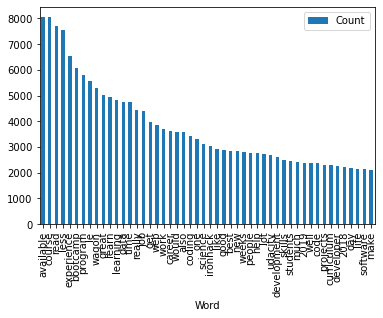

In [8]:

# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('comments.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["le","wagon","false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [1]:
from nltk import word_tokenize
from nltk.corpus import stopwords


In [6]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
print(stopwords.words('english'))
stop_words = set(stopwords.words('english'))
file = open('comments.txt', encoding="utf8")
a= file.read()
word_tokens = word_tokenize(a)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

How many most common words to print:  50



OK. The 50 most common words are as follows

bootcamp :  2283
learn :  2020
coding :  1902
weeks :  1632
really :  1575
code :  1464
experience :  1448
learning :  1421
time :  1251
new :  1238
day :  1220
course :  1216
also :  1198
work :  1136
people :  1123
would :  1122
one :  1114
web :  1070
great :  1066
teachers :  1050
skills :  1039
working :  951
get :  945
like :  908
best :  878
able :  842
first :  838
job :  835
life :  828
always :  825
program :  814
team :  794
help :  784
amazing :  782
project :  780
lot :  726
build :  722
much :  721
decided :  714
could :  702
wanted :  702
years :  694
developer :  687
made :  673
tech :  669
know :  656
make :  656
well :  655
way :  654
even :  653
['bootcamp', 'learn', 'coding', 'weeks', 'really', 'code', 'experience', 'learning', 'time', 'new', 'day', 'course', 'also', 'work', 'people', 'would', 'one', 'web', 'great', 'teachers', 'skills', 'working', 'get', 'like', 'best', 'able', 'first', 'job', 'life', 'always', 'program

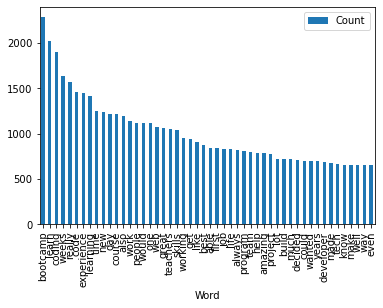

In [9]:

# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('lewagon.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["9", "le", "wagon", "read", "less", "more", "lessle-wagon","false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

lewagon = []
for i in lst:
    for m in i:
        lewagon.append(m)

del lewagon[1::2]
print(lewagon)

##### import collections
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

How many most common words to print:  50



OK. The 50 most common words are as follows

bootcamp :  990
experience :  833
course :  739
job :  686
learn :  613
great :  608
really :  601
time :  596
work :  542
one :  517
also :  505
learning :  477
web :  474
would :  466
career :  449
get :  445
best :  441
people :  424
help :  409
de :  408
like :  404
lot :  392
que :  392
make :  385
always :  369
weeks :  354
staff :  352
learned :  344
new :  330
amazing :  329
good :  326
much :  324
coding :  324
us :  322
even :  315
students :  314
life :  306
week :  301
development :  300
first :  280
working :  272
made :  272
way :  265
program :  264
skills :  261
well :  260
en :  256
design :  252
teachers :  251
feel :  249
['bootcamp', 'experience', 'course', 'job', 'learn', 'great', 'really', 'time', 'work', 'one', 'also', 'learning', 'web', 'would', 'career', 'get', 'best', 'people', 'help', 'de', 'like', 'lot', 'que', 'make', 'always', 'weeks', 'staff', 'learned', 'new', 'amazing', 'good', 'much', 'coding', 'us', 'even'

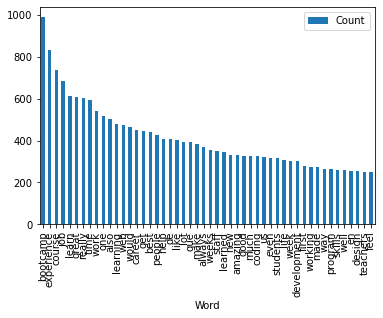

In [10]:

# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('ironhack.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["ironhack", "read", "less", "more", "lessironhack","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

ironhack = []
for i in lst:
    for m in i:
        ironhack.append(m)

del ironhack[1::2]
print(ironhack)

How many most common words to print:  50



OK. The 50 most common words are as follows

course :  1332
class :  633
time :  587
job :  541
great :  481
experience :  481
program :  456
get :  452
work :  444
would :  402
really :  398
learn :  376
instructors :  356
general :  343
career :  317
like :  311
learning :  305
one :  296
also :  292
students :  289
ux :  284
help :  283
much :  278
design :  275
lot :  268
assembly :  264
good :  250
instructor :  245
people :  242
data :  241
new :  236
skills :  220
could :  211
well :  209
take :  195
support :  192
learned :  187
make :  183
us :  181
projects :  181
development :  179
know :  178
web :  177
recommend :  176
even :  175
took :  173
weeks :  172
able :  172
end :  170
way :  170
['course', 'class', 'time', 'job', 'great', 'experience', 'program', 'get', 'work', 'would', 'really', 'learn', 'instructors', 'general', 'career', 'like', 'learning', 'one', 'also', 'students', 'ux', 'help', 'much', 'design', 'lot', 'assembly', 'good', 'instructor', 'people', 'data', 'n

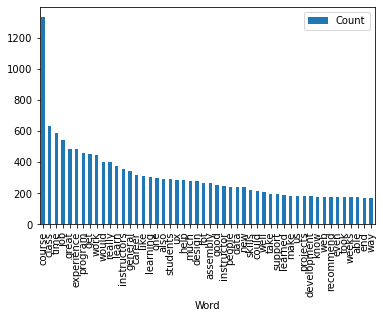

In [11]:

# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('general_assy.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["ga","read", "less", "more", "lessgeneral-assembly","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

general_assy = []
for i in lst:
    for m in i:
        general_assy.append(m)

del general_assy[1::2]
print(general_assy)

How many most common words to print:  50



OK. The 50 most common words are as follows

program :  928
time :  848
curriculum :  810
job :  791
get :  734
learn :  684
course :  643
work :  603
really :  574
experience :  547
would :  487
lot :  472
people :  466
coding :  448
like :  448
much :  434
great :  428
material :  424
learning :  410
one :  405
day :  388
bootcamp :  375
students :  373
programming :  372
weeks :  359
software :  355
week :  354
also :  352
well :  330
months :  328
make :  327
good :  324
hours :  324
help :  318
projects :  298
learned :  298
cohort :  279
feel :  278
first :  276
put :  268
search :  267
every :  267
definitely :  266
able :  265
know :  264
new :  263
hard :  260
end :  258
assessments :  254
way :  243
['program', 'time', 'curriculum', 'job', 'get', 'learn', 'course', 'work', 'really', 'experience', 'would', 'lot', 'people', 'coding', 'like', 'much', 'great', 'material', 'learning', 'one', 'day', 'bootcamp', 'students', 'programming', 'weeks', 'software', 'week', 'also', 'well'

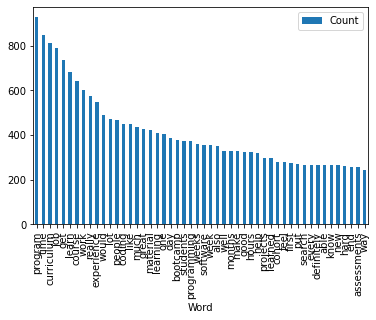

In [12]:

# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('app-aca.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["a/a","app", "academy", "read", "less", "more", "lessapp-academy","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

app_acad = []
for i in lst:
    for m in i:
        app_acad.append(m)

del app_acad[1::2]
print(app_acad)

How many most common words to print:  50



OK. The 50 most common words are as follows

course :  377
python :  262
good :  253
data :  184
learning :  175
instructors :  173
class :  170
lessons :  163
programming :  152
well :  145
helpful :  140
great :  138
teaching :  136
instructor :  127
tas :  121
really :  120
lesson :  116
also :  111
would :  111
learn :  109
coding :  103
understand :  102
us :  101
help :  99
learnt :  96
hackwagon :  96
pace :  93
experience :  87
students :  84
able :  81
pros :  80
easy :  80
knowledge :  79
concepts :  77
clear :  75
basic :  73
content :  73
science :  73
online :  72
provided :  72
time :  70
questions :  68
assistants :  67
lot :  65
fast :  64
basics :  61
taught :  60
always :  58
assignments :  58
recommend :  57
['course', 'python', 'good', 'data', 'learning', 'instructors', 'class', 'lessons', 'programming', 'well', 'helpful', 'great', 'teaching', 'instructor', 'tas', 'really', 'lesson', 'also', 'would', 'learn', 'coding', 'understand', 'us', 'help', 'learnt', 'hackwag

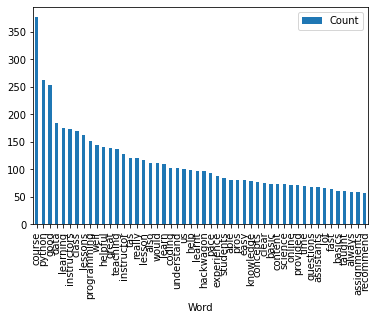

In [13]:

# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('hackwagon.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["read", "less", "more", "lesshackwagon-academy","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

hackwagon = []
for i in lst:
    for m in i:
        hackwagon.append(m)

del hackwagon[1::2]
print(hackwagon)

How many most common words to print:  50



OK. The 50 most common words are as follows

course :  1196
mentor :  755
data :  663
career :  635
ux :  459
program :  419
science :  401
experience :  394
job :  393
curriculum :  365
get :  348
really :  347
time :  342
great :  338
also :  315
design :  310
would :  296
work :  291
learning :  253
projects :  251
track :  235
good :  235
support :  220
help :  216
like :  214
lot :  202
project :  201
learn :  196
recommend :  194
online :  190
one :  185
skills :  183
helpful :  180
well :  177
months :  176
mentors :  173
much :  172
students :  163
able :  161
best :  155
weekly :  152
calls :  150
student :  150
working :  142
industry :  136
capstone :  136
helped :  135
way :  134
portfolio :  132
could :  131
['course', 'mentor', 'data', 'career', 'ux', 'program', 'science', 'experience', 'job', 'curriculum', 'get', 'really', 'time', 'great', 'also', 'design', 'would', 'work', 'learning', 'projects', 'track', 'good', 'support', 'help', 'like', 'lot', 'project', 'learn', 'r

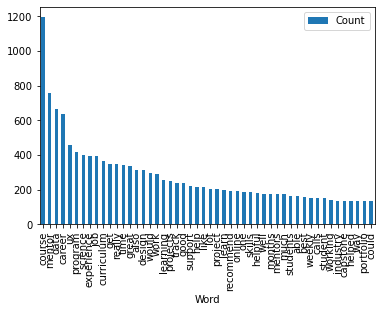

In [33]:
file = open('springboard.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["lessspringboard","springboard","read", "less", "more", "lessthinkful","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

springboard = []
for i in lst:
    for m in i:
        springboard.append(m)

del springboard[1::2]
print(springboard)

##### Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('springboard.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["read", "less", "more", "lessspringboard","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

springboard = []
for i in lst:
    for m in i:
        springboard.append(m)

del springboard[1::2]
print(springboard)

How many most common words to print:  50



OK. The 50 most common words are as follows

program :  510
mentor :  400
course :  397
time :  324
job :  309
get :  299
would :  240
really :  219
help :  216
curriculum :  205
great :  203
also :  200
experience :  197
work :  189
like :  182
one :  180
learning :  173
learn :  172
career :  159
sessions :  144
mentors :  142
web :  139
months :  134
questions :  130
bootcamp :  129
lot :  128
full :  126
students :  125
able :  121
projects :  121
data :  119
much :  118
could :  118
week :  116
development :  111
way :  110
make :  109
good :  109
support :  108
coding :  105
always :  105
i'm :  103
go :  103
well :  99
online :  98
code :  98
working :  98
need :  97
skills :  95
feel :  95
['program', 'mentor', 'course', 'time', 'job', 'get', 'would', 'really', 'help', 'curriculum', 'great', 'also', 'experience', 'work', 'like', 'one', 'learning', 'learn', 'career', 'sessions', 'mentors', 'web', 'months', 'questions', 'bootcamp', 'lot', 'full', 'students', 'able', 'projects', 

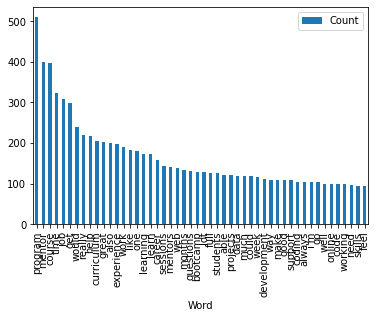

In [15]:
# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('thinkful.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = ["thinkful","read", "less", "more", "lessthinkful","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

thinkful = []
for i in lst:
    for m in i:
        thinkful.append(m)

del thinkful[1::2]
print(thinkful)

How many most common words to print:  50



OK. The 50 most common words are as follows

course :  1019
learning :  644
program :  544
nanodegree :  527
projects :  500
experience :  452
great :  418
get :  412
learn :  404
also :  382
good :  381
really :  381
time :  355
courses :  352
project :  341
job :  336
one :  320
help :  306
new :  299
lot :  285
support :  283
content :  282
would :  268
like :  268
career :  258
well :  247
data :  236
knowledge :  232
best :  223
android :  222
helped :  221
work :  219
students :  212
 :  206
skills :  205
learned :  201
mentor :  200
developer :  198
way :  196
online :  194
programming :  184
end :  183
mentors :  181
many :  180
web :  175
videos :  175
recommend :  174
first :  173
got :  167
much :  165
['course', 'learning', 'program', 'nanodegree', 'projects', 'experience', 'great', 'get', 'learn', 'also', 'good', 'really', 'time', 'courses', 'project', 'job', 'one', 'help', 'new', 'lot', 'support', 'content', 'would', 'like', 'career', 'well', 'data', 'knowledge', 'best',

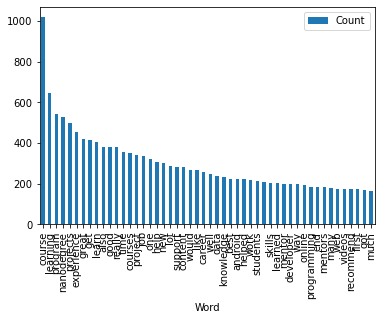

In [16]:
# Read input file, note the encoding is specified here 
# It may be different in your text file
file = open('udacity.txt', encoding="utf8")
a= file.read()
# Stopwords
stopwords = [" :","udacity","read", "more", "less", "lessudacity","|ironhack", "|","|i", "false","true","50", "40", "-", 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

udacity = []
for i in lst:
    for m in i:
        udacity.append(m)

del udacity[1::2]
print(udacity)


In [17]:
while '' in udacity:
    udacity.remove('')

In [119]:
import pandas as pd

In [18]:
from monkeylearn import MonkeyLearn

ml = MonkeyLearn('45c04abb7969f1193a0202145969543b02301bc3')
data = ["course"]
model_id = 'cl_pi3C7JiL'
result = ml.classifiers.classify(model_id, data)
result_stripped = result.body
c = " ".join(str(x) for x in result_stripped)
newstr = c.replace("{'text': '", "")
newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
size = len(newstr4)
mod_string = newstr4[:size - 3]
end_string = mod_string.split(",")
print(end_string)



['course', 'Neutral', '0.657']


In [123]:
df=pd.DataFrame(new_list,columns=['Word','Sentiment','Confidency'])
df.head()

,Word,Sentiment,Confidency
0,course,Neutral,0.657
1,course,Neutral,0.657


In [19]:
new_list = []

for i in udacity:
    ml = MonkeyLearn('45c04abb7969f1193a0202145969543b02301bc3')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list.append(end_string)

print(new_list)

[['course', 'Neutral', '0.657'], ['learning', 'Neutral', '0.749'], ['program', 'Neutral', '0.854'], ['nanodegree', 'Neutral', '0.789'], ['projects', 'Positive', '0.588'], ['experience', 'Neutral', '0.799'], ['great', 'Positive', '0.984'], ['get', 'Neutral', '0.924'], ['learn', 'Neutral', '0.485'], ['also', 'Neutral', '0.789'], ['good', 'Positive', '0.969'], ['really', 'Neutral', '0.734'], ['time', 'Positive', '0.796'], ['courses', 'Neutral', '0.817'], ['project', 'Neutral', '0.506'], ['job', 'Neutral', '0.524'], ['one', 'Neutral', '0.594'], ['help', 'Neutral', '0.779'], ['new', 'Neutral', '0.505'], ['lot', 'Negative', '0.738'], ['support', 'Neutral', '0.51'], ['content', 'Neutral', '0.668'], ['would', 'Neutral', '0.554'], ['like', 'Positive', '0.943'], ['career', 'Neutral', '0.721'], ['well', 'Neutral', '0.538'], ['data', 'Neutral', '0.839'], ['knowledge', 'Neutral', '0.594'], ['best', 'Positive', '0.986'], ['android', 'Neutral', '0.922'], ['helped', 'Neutral', '0.691'], ['work', 'Posi

In [20]:
udacity=pd.DataFrame(new_list,columns=['Word','Sentiment','Confidency'])
udacity.head()

,Word,Sentiment,Confidency
0,course,Neutral,0.657
1,learning,Neutral,0.749
2,program,Neutral,0.854
3,nanodegree,Neutral,0.789
4,projects,Positive,0.588


In [25]:
new_list1 = []

for i in thinkful:
    ml = MonkeyLearn('45c04abb7969f1193a0202145969543b02301bc3')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list1.append(end_string)

print(new_list1)

[['program', 'Neutral', '0.854'], ['mentor', 'Neutral', '0.516'], ['course', 'Neutral', '0.657'], ['time', 'Positive', '0.796'], ['job', 'Neutral', '0.524'], ['get', 'Neutral', '0.924'], ['would', 'Neutral', '0.554'], ['really', 'Neutral', '0.734'], ['help', 'Neutral', '0.779'], ['curriculum', 'Neutral', '0.441'], ['great', 'Positive', '0.984'], ['also', 'Neutral', '0.789'], ['experience', 'Neutral', '0.799'], ['work', 'Positive', '0.9'], ['like', 'Positive', '0.943'], ['one', 'Neutral', '0.594'], ['learning', 'Neutral', '0.749'], ['learn', 'Neutral', '0.485'], ['career', 'Neutral', '0.721'], ['sessions', 'Neutral', '0.849'], ['mentors', 'Positive', '0.475'], ['web', 'Neutral', '0.671'], ['months', 'Neutral', '0.859'], ['questions', 'Neutral', '0.527'], ['bootcamp', 'Negative', '0.592'], ['lot', 'Negative', '0.738'], ['full', 'Neutral', '0.613'], ['students', 'Neutral', '0.864'], ['able', 'Positive', '0.59'], ['projects', 'Positive', '0.588'], ['data', 'Neutral', '0.839'], ['much', 'Ne

In [28]:
thinkful=pd.DataFrame(new_list1,columns=['Word','Sentiment','Confidency'])
thinkful.head()

,Word,Sentiment,Confidency
0,program,Neutral,0.854
1,mentor,Neutral,0.516
2,course,Neutral,0.657
3,time,Positive,0.796
4,job,Neutral,0.524


In [27]:
print(new_list1)

[['program', 'Neutral', '0.854'], ['mentor', 'Neutral', '0.516'], ['course', 'Neutral', '0.657'], ['time', 'Positive', '0.796'], ['job', 'Neutral', '0.524'], ['get', 'Neutral', '0.924'], ['would', 'Neutral', '0.554'], ['really', 'Neutral', '0.734'], ['help', 'Neutral', '0.779'], ['curriculum', 'Neutral', '0.441'], ['great', 'Positive', '0.984'], ['also', 'Neutral', '0.789'], ['experience', 'Neutral', '0.799'], ['work', 'Positive', '0.9'], ['like', 'Positive', '0.943'], ['one', 'Neutral', '0.594'], ['learning', 'Neutral', '0.749'], ['learn', 'Neutral', '0.485'], ['career', 'Neutral', '0.721'], ['sessions', 'Neutral', '0.849'], ['mentors', 'Positive', '0.475'], ['web', 'Neutral', '0.671'], ['months', 'Neutral', '0.859'], ['questions', 'Neutral', '0.527'], ['bootcamp', 'Negative', '0.592'], ['lot', 'Negative', '0.738'], ['full', 'Neutral', '0.613'], ['students', 'Neutral', '0.864'], ['able', 'Positive', '0.59'], ['projects', 'Positive', '0.588'], ['data', 'Neutral', '0.839'], ['much', 'Ne

In [34]:
new_list2 = []

for i in springboard:
    ml = MonkeyLearn('45c04abb7969f1193a0202145969543b02301bc3')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list2.append(end_string)

print(new_list2)

[['course', 'Neutral', '0.657'], ['mentor', 'Neutral', '0.516'], ['data', 'Neutral', '0.839'], ['career', 'Neutral', '0.721'], ['ux', 'Neutral', '0.6'], ['program', 'Neutral', '0.854'], ['science', 'Neutral', '0.691'], ['experience', 'Neutral', '0.799'], ['job', 'Neutral', '0.524'], ['curriculum', 'Neutral', '0.441'], ['get', 'Neutral', '0.924'], ['really', 'Neutral', '0.734'], ['time', 'Positive', '0.796'], ['great', 'Positive', '0.984'], ['also', 'Neutral', '0.789'], ['design', 'Positive', '0.425'], ['would', 'Neutral', '0.554'], ['work', 'Positive', '0.9'], ['learning', 'Neutral', '0.749'], ['projects', 'Positive', '0.588'], ['track', 'Neutral', '0.735'], ['good', 'Positive', '0.969'], ['support', 'Neutral', '0.51'], ['help', 'Neutral', '0.779'], ['like', 'Positive', '0.943'], ['lot', 'Negative', '0.738'], ['project', 'Neutral', '0.506'], ['learn', 'Neutral', '0.485'], ['recommend', 'Neutral', '0.439'], ['online', 'Neutral', '0.806'], ['one', 'Neutral', '0.594'], ['skills', 'Neutral

In [35]:
springboard=pd.DataFrame(new_list2,columns=['Word','Sentiment','Confidency'])
springboard.head()

,Word,Sentiment,Confidency
0,course,Neutral,0.657
1,mentor,Neutral,0.516
2,data,Neutral,0.839
3,career,Neutral,0.721
4,ux,Neutral,0.6


In [36]:
new_list3 = []

for i in nyc_data:
    ml = MonkeyLearn('45c04abb7969f1193a0202145969543b02301bc3')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list3.append(end_string)

print(new_list3)

[['data', 'Neutral', '0.839'], ['science', 'Neutral', '0.691'], ['bootcamp', 'Negative', '0.592'], ['learning', 'Neutral', '0.749'], ['job', 'Neutral', '0.524'], ['course', 'Neutral', '0.657'], ['experience', 'Neutral', '0.799'], ['python', 'Neutral', '0.902'], ['program', 'Neutral', '0.854'], ['students', 'Neutral', '0.864'], ['projects', 'Positive', '0.588'], ['time', 'Positive', '0.796'], ['also', 'Neutral', '0.789'], ['academy', 'Negative', '0.677'], ['get', 'Neutral', '0.924'], ['nycdsa', 'Neutral', '0.757'], ['great', 'Positive', '0.984'], ['nyc', 'Neutral', '0.771'], ['r', 'Neutral', '0.653'], ['work', 'Positive', '0.9'], ['machine', 'Neutral', '0.704'], ['career', 'Neutral', '0.721'], ['learn', 'Neutral', '0.485'], ['class', 'Positive', '0.904'], ['instructors', 'Neutral', '0.586'], ['well', 'Neutral', '0.538'], ['skills', 'Neutral', '0.534'], ['would', 'Neutral', '0.554'], ['really', 'Neutral', '0.734'], ['lot', 'Negative', '0.738'], ['recommend', 'Neutral', '0.439'], ['people

In [37]:
nyc_data=pd.DataFrame(new_list3,columns=['Word','Sentiment','Confidency'])
nyc_data.head()

,Word,Sentiment,Confidency
0,data,Neutral,0.839
1,science,Neutral,0.691
2,bootcamp,Negative,0.592
3,learning,Neutral,0.749
4,job,Neutral,0.524


In [38]:
new_list4 = []

for i in hackwagon:
    ml = MonkeyLearn('45c04abb7969f1193a0202145969543b02301bc3')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list4.append(end_string)

print(new_list4)

[['course', 'Neutral', '0.657'], ['python', 'Neutral', '0.902'], ['good', 'Positive', '0.969'], ['data', 'Neutral', '0.839'], ['learning', 'Neutral', '0.749'], ['instructors', 'Neutral', '0.586'], ['class', 'Positive', '0.904'], ['lessons', 'Neutral', '0.437'], ['programming', 'Neutral', '0.66'], ['well', 'Neutral', '0.538'], ['helpful', 'Positive', '0.773'], ['great', 'Positive', '0.984'], ['teaching', 'Neutral', '0.628'], ['instructor', 'Neutral', '0.761'], ['tas', 'Positive', '0.808'], ['really', 'Neutral', '0.734'], ['lesson', 'Neutral', '0.734'], ['also', 'Neutral', '0.789'], ['would', 'Neutral', '0.554'], ['learn', 'Neutral', '0.485'], ['coding', 'Neutral', '0.804'], ['understand', 'Neutral', '0.673'], ['us', 'Positive', '0.373'], ['help', 'Neutral', '0.779'], ['learnt', 'Neutral', '0.907'], ['hackwagon', 'Neutral', '0.806'], ['pace', 'Neutral', '0.567'], ['experience', 'Neutral', '0.799'], ['students', 'Neutral', '0.864'], ['able', 'Positive', '0.59'], ['pros', 'Neutral', '0.619

In [39]:
hackwagon=pd.DataFrame(new_list4,columns=['Word','Sentiment','Confidency'])
hackwagon.head()

,Word,Sentiment,Confidency
0,course,Neutral,0.657
1,python,Neutral,0.902
2,good,Positive,0.969
3,data,Neutral,0.839
4,learning,Neutral,0.749


In [40]:
new_list5 = []

for i in app_acad:
    ml = MonkeyLearn('974d462007f6fd83c9bb2426ecf6c3b4d0aa69b8')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list5.append(end_string)

print(new_list5)

[['program', 'Neutral', '0.854'], ['time', 'Positive', '0.796'], ['curriculum', 'Neutral', '0.441'], ['job', 'Neutral', '0.524'], ['get', 'Neutral', '0.924'], ['learn', 'Neutral', '0.485'], ['course', 'Neutral', '0.657'], ['work', 'Positive', '0.9'], ['really', 'Neutral', '0.734'], ['experience', 'Neutral', '0.799'], ['would', 'Neutral', '0.554'], ['lot', 'Negative', '0.738'], ['people', 'Neutral', '0.545'], ['coding', 'Neutral', '0.804'], ['like', 'Positive', '0.943'], ['much', 'Neutral', '0.564'], ['great', 'Positive', '0.984'], ['material', 'Neutral', '0.528'], ['learning', 'Neutral', '0.749'], ['one', 'Neutral', '0.594'], ['day', 'Neutral', '0.929'], ['bootcamp', 'Negative', '0.592'], ['students', 'Neutral', '0.864'], ['programming', 'Neutral', '0.66'], ['weeks', 'Neutral', '0.816'], ['software', 'Neutral', '0.837'], ['week', 'Neutral', '0.826'], ['also', 'Neutral', '0.789'], ['well', 'Neutral', '0.538'], ['months', 'Neutral', '0.859'], ['make', 'Negative', '0.901'], ['good', 'Posi

In [41]:
app_acad=pd.DataFrame(new_list5,columns=['Word','Sentiment','Confidency'])
app_acad.head()

,Word,Sentiment,Confidency
0,program,Neutral,0.854
1,time,Positive,0.796
2,curriculum,Neutral,0.441
3,job,Neutral,0.524
4,get,Neutral,0.924


In [42]:
new_list6 = []

for i in general_assy:
    ml = MonkeyLearn('974d462007f6fd83c9bb2426ecf6c3b4d0aa69b8')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list6.append(end_string)

print(new_list6)

[['course', 'Neutral', '0.657'], ['class', 'Positive', '0.904'], ['time', 'Positive', '0.796'], ['job', 'Neutral', '0.524'], ['great', 'Positive', '0.984'], ['experience', 'Neutral', '0.799'], ['program', 'Neutral', '0.854'], ['get', 'Neutral', '0.924'], ['work', 'Positive', '0.9'], ['would', 'Neutral', '0.554'], ['really', 'Neutral', '0.734'], ['learn', 'Neutral', '0.485'], ['instructors', 'Neutral', '0.586'], ['general', 'Neutral', '0.64'], ['career', 'Neutral', '0.721'], ['like', 'Positive', '0.943'], ['learning', 'Neutral', '0.749'], ['one', 'Neutral', '0.594'], ['also', 'Neutral', '0.789'], ['students', 'Neutral', '0.864'], ['ux', 'Neutral', '0.6'], ['help', 'Neutral', '0.779'], ['much', 'Neutral', '0.564'], ['design', 'Positive', '0.425'], ['lot', 'Negative', '0.738'], ['assembly', 'Positive', '0.544'], ['good', 'Positive', '0.969'], ['instructor', 'Neutral', '0.761'], ['people', 'Neutral', '0.545'], ['data', 'Neutral', '0.839'], ['new', 'Neutral', '0.505'], ['skills', 'Neutral',

In [43]:
general_assy=pd.DataFrame(new_list6,columns=['Word','Sentiment','Confidency'])
general_assy.head()

,Word,Sentiment,Confidency
0,course,Neutral,0.657
1,class,Positive,0.904
2,time,Positive,0.796
3,job,Neutral,0.524
4,great,Positive,0.984


In [44]:
new_list7 = []

for i in ironhack:
    ml = MonkeyLearn('974d462007f6fd83c9bb2426ecf6c3b4d0aa69b8')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list7.append(end_string)

print(new_list7)

[['bootcamp', 'Negative', '0.592'], ['experience', 'Neutral', '0.799'], ['course', 'Neutral', '0.657'], ['job', 'Neutral', '0.524'], ['learn', 'Neutral', '0.485'], ['great', 'Positive', '0.984'], ['really', 'Neutral', '0.734'], ['time', 'Positive', '0.796'], ['work', 'Positive', '0.9'], ['one', 'Neutral', '0.594'], ['also', 'Neutral', '0.789'], ['learning', 'Neutral', '0.749'], ['web', 'Neutral', '0.671'], ['would', 'Neutral', '0.554'], ['career', 'Neutral', '0.721'], ['get', 'Neutral', '0.924'], ['best', 'Positive', '0.986'], ['people', 'Neutral', '0.545'], ['help', 'Neutral', '0.779'], ['de', 'Positive', '0.495'], ['like', 'Positive', '0.943'], ['lot', 'Negative', '0.738'], ['que', 'Neutral', '0.525'], ['make', 'Negative', '0.901'], ['always', 'Neutral', '0.619'], ['weeks', 'Neutral', '0.816'], ['staff', 'Neutral', '0.661'], ['learned', 'Neutral', '0.896'], ['new', 'Neutral', '0.505'], ['amazing', 'Positive', '0.986'], ['good', 'Positive', '0.969'], ['much', 'Neutral', '0.564'], ['co

In [45]:
ironhack=pd.DataFrame(new_list7,columns=['Word','Sentiment','Confidency'])
ironhack

,Word,Sentiment,Confidency
0,bootcamp,Negative,0.592
1,experience,Neutral,0.799
2,course,Neutral,0.657
3,job,Neutral,0.524
4,learn,Neutral,0.485
5,great,Positive,0.984
6,really,Neutral,0.734
7,time,Positive,0.796
8,work,Positive,0.9
9,one,Neutral,0.594


In [46]:
new_list8 = []

for i in lewagon:
    ml = MonkeyLearn('974d462007f6fd83c9bb2426ecf6c3b4d0aa69b8')
    data = [i]
    model_id = 'cl_pi3C7JiL'
    result = ml.classifiers.classify(model_id, data)
    result_stripped = result.body
    result_stripped = result.body
    c = " ".join(str(x) for x in result_stripped)
    newstr = c.replace("{'text': '", "")
    newstr1 = newstr.replace("', 'external_id': None, 'error': False, 'classifications': [{'tag_name': '", ",")
    newstr2 = newstr1.replace("', 'tag_id': 122921383, 'confidence': ", ",")
    newstr3 = newstr2.replace("', 'tag_id': 122921384, 'confidence': ", ",")
    newstr4 = newstr3.replace("', 'tag_id': 122921385, 'confidence': ", ",")
    size = len(newstr4)
    mod_string = newstr4[:size - 3]
    end_string = mod_string.split(",")
    new_list8.append(end_string)

print(new_list8)

[['bootcamp', 'Negative', '0.592'], ['learn', 'Neutral', '0.485'], ['coding', 'Neutral', '0.804'], ['weeks', 'Neutral', '0.816'], ['really', 'Neutral', '0.734'], ['code', 'Neutral', '0.633'], ['experience', 'Neutral', '0.799'], ['learning', 'Neutral', '0.749'], ['time', 'Positive', '0.796'], ['new', 'Neutral', '0.505'], ['day', 'Neutral', '0.929'], ['course', 'Neutral', '0.657'], ['also', 'Neutral', '0.789'], ['work', 'Positive', '0.9'], ['people', 'Neutral', '0.545'], ['would', 'Neutral', '0.554'], ['one', 'Neutral', '0.594'], ['web', 'Neutral', '0.671'], ['great', 'Positive', '0.984'], ['teachers', 'Neutral', '0.659'], ['skills', 'Neutral', '0.534'], ['working', 'Positive', '0.573'], ['get', 'Neutral', '0.924'], ['like', 'Positive', '0.943'], ['best', 'Positive', '0.986'], ['able', 'Positive', '0.59'], ['first', 'Negative', '0.659'], ['job', 'Neutral', '0.524'], ['life', 'Neutral', '0.649'], ['always', 'Neutral', '0.619'], ['program', 'Neutral', '0.854'], ['team', 'Neutral', '0.85'],

In [47]:
lewagon=pd.DataFrame(new_list8,columns=['Word','Sentiment','Confidency'])
lewagon.head()

,Word,Sentiment,Confidency
0,bootcamp,Negative,0.592
1,learn,Neutral,0.485
2,coding,Neutral,0.804
3,weeks,Neutral,0.816
4,really,Neutral,0.734


In [48]:
Negative = lewagon[lewagon['Sentiment'] == "Negative"]

In [49]:
Neutral = lewagon[lewagon['Sentiment'] == "Neutral"]

In [50]:
Positive = lewagon[lewagon['Sentiment'] == "Positive"]

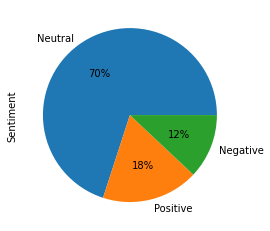

In [51]:
lewagon['Sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [52]:
lewagon['School'] = "Lewagon"

In [53]:
ironhack['School'] = "Ironhack"

In [54]:
springboard['School'] = "Springboard"

In [55]:
thinkful['School'] = "Thinkful"

In [56]:
udacity['School'] = "Udacity"

In [57]:
nyc_data['School'] = "Nyc-data-science-academy"

In [58]:
general_assy['School'] = "General-assembly"

In [59]:
hackwagon['School'] = "Hackwagon-academy"

In [60]:
app_acad['School'] = "App-academy"

In [61]:
All_schools = pd.DataFrame()

In [62]:
frames = [lewagon, ironhack, springboard, thinkful, udacity, nyc_data, general_assy, hackwagon,app_acad]

result = pd.concat(frames)

In [63]:
result.head()

,Word,Sentiment,Confidency,School
0,bootcamp,Negative,0.592,Lewagon
1,learn,Neutral,0.485,Lewagon
2,coding,Neutral,0.804,Lewagon
3,weeks,Neutral,0.816,Lewagon
4,really,Neutral,0.734,Lewagon


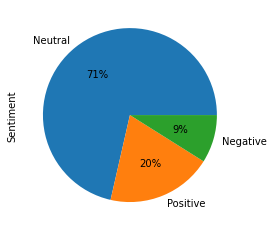

In [64]:
result['Sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

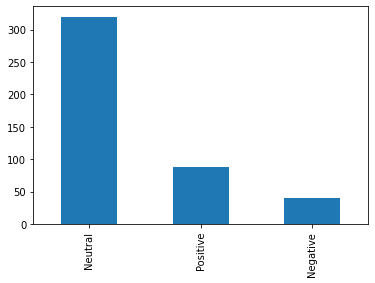

In [65]:
result['Sentiment'].value_counts().plot(kind='bar')

In [66]:
Negative = result[result['Sentiment'] == "Negative"]
Neutral = result[result['Sentiment'] == "Neutral"]
Positive = result[result['Sentiment'] == "Positive"]

In [67]:
result

,Word,Sentiment,Confidency,School
0,bootcamp,Negative,0.592,Lewagon
1,learn,Neutral,0.485,Lewagon
2,coding,Neutral,0.804,Lewagon
3,weeks,Neutral,0.816,Lewagon
4,really,Neutral,0.734,Lewagon
...,...,...,...,...
45,new,Neutral,0.505,App-academy
46,hard,Neutral,0.444,App-academy
47,end,Neutral,0.599,App-academy
48,assessments,Neutral,0.865,App-academy


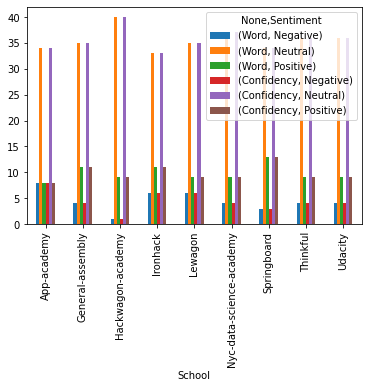

In [68]:
result_plot = result.groupby(["School",'Sentiment']).count().unstack()
result_plot.plot(kind='bar')

In [69]:
complete_dataframe = result

In [70]:
del result['Confidency']

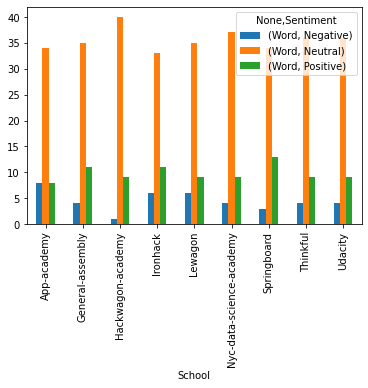

In [71]:
result_plot = result.groupby(["School",'Sentiment']).count().unstack()
result_plot.plot(kind='bar')

In [75]:
Negative = result[result['Sentiment'] == "Negative"]
Neutral = result[result['Sentiment'] == "Neutral"]
Positive = result[result['Sentiment'] == "Positive"]

In [83]:
result.groupby('Sentiment').count()

,Word,School
Sentiment,,
Negative,40,40
Neutral,320,320
Positive,88,88


In [99]:
overall_ratio_pos = 88/128
overall_ratio_pos
overall_ratio_neg = 40/128
overall_ratio_neg

0.3125

In [84]:
lewagon.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,6,6,6
Neutral,35,35,35
Positive,9,9,9


In [95]:
lewagon_ratio = 6/9
lewagon_ratio

0.6666666666666666

In [85]:
ironhack.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,6,6,6
Neutral,33,33,33
Positive,11,11,11


In [96]:
ironhack_ratio = 6/11
ironhack_ratio

0.5454545454545454

In [86]:
springboard.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,3,3,3
Neutral,34,34,34
Positive,13,13,13


In [87]:
thinkful.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,4,4,4
Neutral,36,36,36
Positive,9,9,9


In [88]:
udacity.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,4,4,4
Neutral,36,36,36
Positive,9,9,9


In [89]:
nyc_data.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,4,4,4
Neutral,37,37,37
Positive,9,9,9


In [90]:
general_assy.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,4,4,4
Neutral,35,35,35
Positive,11,11,11


In [91]:
hackwagon.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,1,1,1
Neutral,40,40,40
Positive,9,9,9


In [92]:
app_acad.groupby('Sentiment').count()

,Word,Confidency,School
Sentiment,,,
Negative,8,8,8
Neutral,34,34,34
Positive,8,8,8
